In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.y=(df.y=='yes').astype(int)

In [4]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [5]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = []
for column in df.columns:
    if column not in categorical:
        numerical.append(column)
        
print(numerical)
print(categorical)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [6]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

df_full_train = df_full_train.reset_index()
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [7]:
from sklearn.metrics import roc_auc_score

# Dictionary to store AUC results
auc_scores = {}

# Loop through each numerical feature and calculate the AUC
for feature in numerical:
    # Calculate AUC for the feature
    auc_score = roc_auc_score(df_train['y'], df_train[feature])
    
    # Check if AUC is below 0.5, if so, negate the feature
    if auc_score < 0.5:
        auc_score = roc_auc_score(df_train['y'], -df_train[feature])
    
    # Store the AUC score for this feature
    auc_scores[feature] = auc_score
    print(f'{feature}: AUC = {auc_score:.3f}')

# Find the feature with the highest AUC
best_feature = max(auc_scores, key=auc_scores.get)
print(f'\nThe numerical feature with the highest AUC is {best_feature}, with an AUC of {auc_scores[best_feature]:.3f}')


age: AUC = 0.512
balance: AUC = 0.589
day: AUC = 0.526
duration: AUC = 0.815
campaign: AUC = 0.571
pdays: AUC = 0.590
previous: AUC = 0.599
y: AUC = 1.000

The numerical feature with the highest AUC is y, with an AUC of 1.000


In [8]:
columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [9]:
datasets = [df_full_train, df_train, df_test, df_val]

for dataset in datasets:
    dataset = dataset[columns]

from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse = False)

train_dict = df_train[columns].to_dict(orient = 'records')
y_train = df_train.y.values
del df_train['y']
X_train = dv.fit_transform(train_dict)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [10]:
val_dict = df_val[columns].to_dict(orient = 'records')
y_val = df_val.y.values
del df_val['y']
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.77

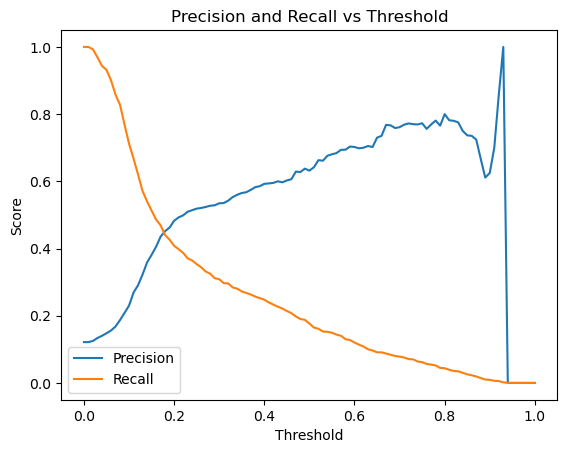

In [12]:
from sklearn.metrics import precision_score, recall_score
# Initialize lists to store scores and thresholds
scores = []
thresholds = np.linspace(0.0, 1.0, 101)  # Fixed the threshold generation

# Loop over thresholds and compute precision and recall
for t in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    y_pred_binary = (y_pred >= t).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    
    # Store the results
    scores.append((t, precision, recall))

# Create a DataFrame to hold the precision and recall scores
df_scores = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall'])

# Plot precision and recall curves
plt.plot(df_scores['threshold'], df_scores['precision'], label='Precision')
plt.plot(df_scores['threshold'], df_scores['recall'], label='Recall')

# Add labels and legends
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.show()

In [13]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds: 
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <= t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f1_score = 2 * ((p * r) / (p + r))
    
    scores.append((t, p, r, f1_score))

columns = ['threshold', 'precision', 'recall', 'f1_score']
df_scores = pd.DataFrame(scores, columns = columns)

max_f1_score = df_scores['f1_score'].max()
print(max_f1_score)
df_scores[df_scores['f1_score'] == max_f1_score].threshold


0.45155633494081543


17    0.17
Name: threshold, dtype: float64

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver = 'liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [23]:
def predict(df, dv, model):
    dicts = df[categorical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
from sklearn.model_selection import KFold 

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
scores = []

for train_idx, val_idx in kfold.split(df_train):
    df_train = df.iloc[train_idx]
    df_val = df.iloc[val_idx]
    
    y_train = df_train.y.values
    y_val = df_val.y.values
    
    dv, model = train(df_train, y_train, C = 1)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
std = np.array(scores).std()
std

0.01328379046052006

In [25]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        # the k-fold split uses index to shuffle the data
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.y.values
        y_val = df_val.y.values
        
        # training and predicting
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        # AUC
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C= %s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C= 1e-06 0.569 +- 0.019
C= 0.001 0.574 +- 0.021
C= 1 0.573 +- 0.012
